# Appendix: Numerical Optimization

This notebook uses the `Optim` package (https://github.com/JuliaNLSolvers/Optim.jl) which has general-purpose optimization routines.

As an alternative, we consider the `NLopt` package (https://github.com/JuliaOpt/NLopt.jl) towards the end of the notebook.

## Load Packages

In [1]:
using Optim, Dates

include("jlFiles/printmat.jl")

printlnPs (generic function with 2 methods)

In [2]:
using Plots
backend = "gr"              #"gr" (default), "pyplot" 

if backend == "pyplot"
    pyplot(size=(600,400))
else    
    gr(size=(480,320))
    default(fmt = :svg)
end

# Unconstrained Optimization

In the example below, we want to choose $(x,y)$ so as to minimize the fairly simple objective function

$
(x-2)^2 + (4y+3)^2,  
$

without any constraints. Yes, the solution should be $(x,y)=(2,-3/4)$.


In the next few cells, we 

(1) define the loss function and calculate its value on a grid of (x,y) values

(2) plot the contours of the loss function (and then also the surface)

(3) do a numerical minimization to find the optimal values

In [3]:
function lossfun(p::Vector)
    (x,y) = (p[1],p[2])          #unpack the choice variables and get nicer names
     L    = (x-2)^2 + (4*y+3)^2
    return L
end

lossfun (generic function with 1 method)

In [4]:
nx = 2*41
ny = 2*61
x = range(1,stop=5,length=nx)    
y = range(-1,stop=0,length=ny)

loss2d = fill(NaN,(nx,ny))      #matrix with loss fn values
for i = 1:nx, j = 1:ny                   
    loss2d[i,j] = lossfun([x[i];y[j]])
end

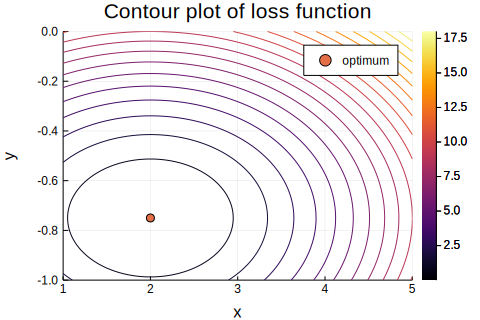

In [5]:
p1 = contour(x,y,copy(loss2d'),xlims=(1,5),ylims=(-1,0),legend=true,levels=21)  #notice: copy(loss2d')
scatter!([2],[-0.75],label="optimum")
title!("Contour plot of loss function")
xlabel!("x")
ylabel!("y")

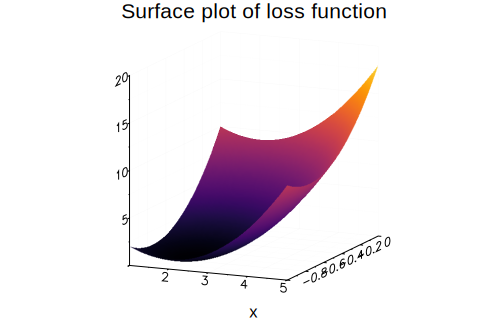

In [6]:
p1 = surface(x,y,copy(loss2d'),legend=false)   
title!("Surface plot of loss function")
xlabel!("x")

In [7]:
Sol = optimize(lossfun,[0.0;0.0])    #use p->lossfn(p,other arguments) if 
                                     #there are additional (non-choice) arguments
printlnPs("minimum at (x,y)= ",Optim.minimizer(Sol))

minimum at (x,y)=      2.000    -0.750


# Optimization with Bounds on the Parameters

The next few cells discuss two different ways of imposing bounds like $a \leq x$, by transforming the parameters or by letting `optimize` do the work for you.

## Approach I: Transforming the Parameters

A simple way to handle a lower bound like $a \leq x$ is to let the optimization routine optimize with respect to a transformed variable $xb=\ln(x-a)$. Inside the loss function (and also after having obtained the minimizer) we transform back to $x$ by $x = \exp(xb) + a$.

Instead, with an upper bound $x\leq b$, we instead optimize over $xb = \ln(b-x)$ and we transform back to $x$ by $x = b- \exp(xb)$.

In the example below, we impose $2.75 \leq x$ (a lower bound) and $y \leq -0.3$ (an upper bound). We will see that only of these restrictions binds.

In [8]:
function lossfun4(p::Vector)
    (xb,yb) = (p[1],p[2])        
    x = exp(xb) + 2.75                       #transform to x
    y = -0.3 - exp(yb)                       #transform to y
    L = lossfun([x;y])
  return L
end

lossfun4 (generic function with 1 method)

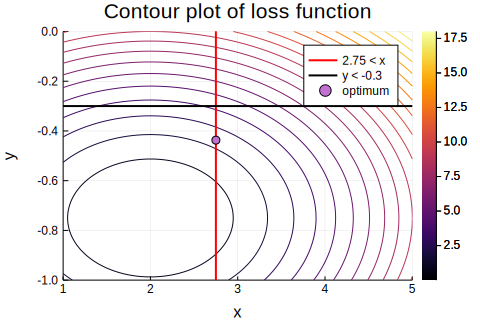

In [9]:
p1 = contour(x,y,copy(loss2d'),xlims=(1,5),ylims=(-1,0),legend=true,levels=21) 
plot!([2.75,2.75],[-1,0.5],color=:red,linewidth=2,label="2.75 < x")
plot!([1,5],[-0.3,-0.3],color=:black,linewidth=2,label="y < -0.3")
scatter!([2.75],[-0.437],label="optimum")
title!("Contour plot of loss function")
xlabel!("x")
ylabel!("y")

In [10]:
par0 = [log(3-2.75);log(-0.3-(-0.7))]        #initial guess obeys restrictions

Sol   = optimize(lossfun4,par0)
par1b = Optim.minimizer(Sol)

par1 = [exp(par1b[1])+2.75;(-0.3-exp(par1b[2]))]     #transform par1b to x and y

printlnPs("The optimin is at (x,y)= ",par1)

The optimin is at (x,y)=      2.750    -0.750


## Approach II: Using the "Box Constrained Optimization" in Optim.jl

This approach is very easy. In particular, you can use the original (not transformed) loss function.

You just need to supply the bounds on the choice variables. Make sure that the initial guess must satisfy the bounds.

In [11]:
lower = [2.75, -Inf]
upper = [Inf, -0.3]

Sol = optimize(lossfun,lower,upper,[3.0,-0.5])   

printlnPs("The optimin is at (x,y)= ",Optim.minimizer(Sol))

The optimin is at (x,y)=      2.750    -0.750


# Optimization with Equality Constraints (extra)

We now impose the constraint that 

$
x+2y-3=0.
$

This clearly means that $x=3-2y$. In this simple case, we could rewrite the optimization problem in terms of $y$ only. However, this might be tricky with other types of constraints, so we instead illustrate a more general apporach.

We do this by adding a penalty term $\lambda(x+2y-3)^2$ to the loss function. 


In the next few cells, we 

1. Plot the loss function together with the constraint
    
2. redefine the loss function to also include a penalty for violating the constraint

3. solve for and and plot the optimal values as we impose a higher and higher penalty ($\lambda$) on violating the constraint, starting from $\lambda=0$ and then using the solution as the starting guess for the next iteration.

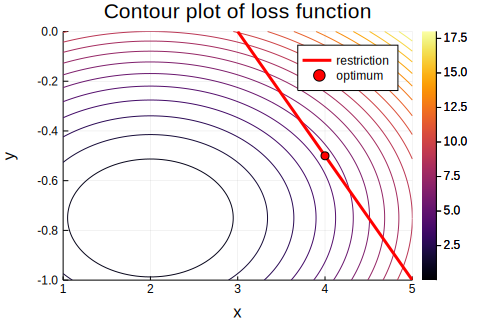

In [12]:
p1 = contour(x,y,copy(loss2d'),xlims=(1,5),ylims=(-1,0),legend=true,levels=21) 
plot!(3 .- 2*y,y,color=:red,linewidth=3,label="restriction")
scatter!([4],[-0.5],color=:red,label="optimum")
title!("Contour plot of loss function")
xlabel!("x")
ylabel!("y")

In [13]:
function lossfun2(p::Vector,lambda)
    (x,y) = (p[1],p[2])          #unpack the choice variables    
    L1 = lossfun([x;y])
    c  = x + 2*y - 3             #equality restriction
    L  = L1 + lambda*c^2
  return L
end

lossfun2 (generic function with 1 method)

In [14]:
println("\nRestricted minima from harder and harder punishment of the constraint violation")
println("iteration,    lambda,  x + 2.5*y - 3,  x,    y")
Δpar = Inf
par0 = [2.5;0.0]                  #initial guess obeys restriction
parM = fill(NaN,(500,2))
i = 1
while maximum(abs.(Δpar)) > 1e-4
    #global Δpar, i, par0         #only needed in REPL/scripts
    local λ, Sol, par1, x, y, c   #to not overwrite outside variables 
    λ    = (i-1)*2
    Sol  = optimize(par->lossfun2(par,λ),par0)   #notice par->lossfun2()
    par1 = Optim.minimizer(Sol)
    (x,y) = (par1[1],par1[2]) 
    c    = x + 2*y - 3 
    printlnPs(i,λ,c,par1)
    parM[i,:] = par1                 #store in array
    Δpar      = par1 - par0          #change in parameter values
    par0      = copy(par1)           #starting guess in next iteration
    i         = i + 1
end

println("\nCompare with the contour plot above")


Restricted minima from harder and harder punishment of the constraint violation
iteration,    lambda,  x + 2.5*y - 3,  x,    y
         1         0    -2.500     2.000    -0.750
         2         2    -0.714     3.429    -0.571
         3         4    -0.417     3.667    -0.542
         4         6    -0.294     3.765    -0.529
         5         8    -0.227     3.818    -0.523
         6        10    -0.185     3.852    -0.519
         7        12    -0.156     3.875    -0.516
         8        14    -0.135     3.892    -0.514
         9        16    -0.119     3.905    -0.512
        10        18    -0.106     3.915    -0.511
        11        20    -0.096     3.923    -0.510
        12        22    -0.088     3.930    -0.509
        13        24    -0.081     3.935    -0.508
        14        26    -0.075     3.940    -0.507
        15        28    -0.069     3.944    -0.507
        16        30    -0.065     3.948    -0.506
        17        32    -0.061     3.951    -0.506
     

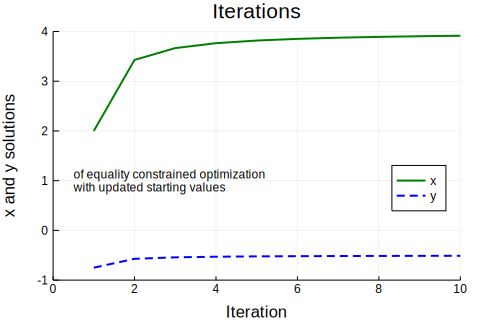

In [15]:
p1 = plot(1:10,parM[1:10,1],color=:green,linewidth=2,label="x",xlim=(0,10),ylim=(-1,4))
plot!(1:10,parM[1:10,2],line=:dash,color=:blue,linewidth=2,label="y",legend=:right)
title!("Iterations")
xlabel!("Iteration")
ylabel!("x and y solutions")
annotate!(0.5,1,text("of equality constrained optimization\nwith updated starting values",8,:left))

# Optimization with Inequality Constraints (extra)

We now impose the constraint that $y \le -(x-4)^2$, so $y+(x-4)^2 \le 0$ by defining

$
r = y + (x-4)^2
$,

and adding a penalty term $\rho \max(0,r)^2$ to the loss function and then iterate (higher and higher $\rho$, using the previous solution as the starting guess).

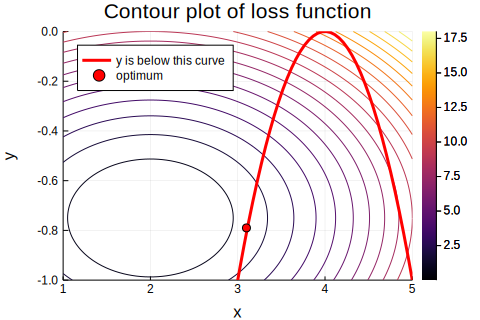

In [16]:
yRestriction = -(x.-4).^2               #y should be less than this

p1 = contour(x,y,copy(loss2d'),levels=21) 
plot!(x,yRestriction,xlims=(1,5),ylims=(-1,0),color=:red,linewidth=3,label="y is below this curve")
scatter!([3.1],[-0.79],color=:red,label="optimum",legend=:topleft)
title!("Contour plot of loss function")
xlabel!("x")
ylabel!("y")

In [17]:
function lossfun3(p::Vector,rho)
    (x,y) = (p[1],p[2])          #unpack the choice variables    
    L1 = lossfun([x;y])
    r  = y + (x-4)^2             #inequality restriction, <=
    L  = L1 + rho*max(0,r)^2
  return L
end

lossfun3 (generic function with 1 method)

In [18]:
println("\nRestricted optima")
println("iteration,        rho,  y+(x-4)^2,  x,      y")
Δpar = Inf
par0 = [4.0;-0.1]                   #initial guess obeys restriction
parMb = fill(NaN,(500,2))
i = 1
while maximum(abs.(Δpar)) > 1e-4
    #global Δpar, i, par0           #only needed in REPL/scripts
    local ρ, Sol, par1, x, y, r
    ρ    = (i-1)*2
    Sol  = optimize(par->lossfun3(par,ρ),par0)
    par1 = Optim.minimizer(Sol)
    (x,y) = (par1[1],par1[2])
    r    = y + (x-4)^2
    printlnPs(i,ρ,r, par1)
    parMb[i,:] = par1
    Δpar       = par1 - par0
    par0       = copy(par1)
    i          = i + 1
end


Restricted optima
iteration,        rho,  y+(x-4)^2,  x,      y
         1         0     3.250     2.000    -0.750
         2         2     0.244     2.988    -0.781
         3         4     0.136     3.041    -0.784
         4         6     0.094     3.062    -0.785
         5         8     0.072     3.073    -0.786
         6        10     0.059     3.081    -0.787
         7        12     0.049     3.085    -0.787
         8        14     0.043     3.089    -0.787
         9        16     0.038     3.092    -0.788
        10        18     0.034     3.094    -0.788
        11        20     0.030     3.096    -0.788
        12        22     0.028     3.097    -0.788
        13        24     0.025     3.098    -0.788
        14        26     0.023     3.099    -0.788
        15        28     0.022     3.100    -0.788
        16        30     0.020     3.101    -0.788
        17        32     0.019     3.101    -0.788
        18        34     0.018     3.102    -0.788
        19       

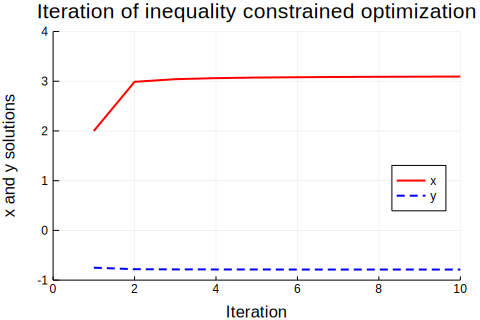

In [19]:
p1 = plot(1:10,parMb[1:10,1],color=:red,linewidth=2,label="x",xlim=(0,10),ylim=(-1,4))
plot!(1:10,parMb[1:10,2],line=:dash,color=:blue,linewidth=2,label="y",legend=:right)
title!("Iteration of inequality constrained optimization")
xlabel!("Iteration")
ylabel!("x and y solutions")

# Solving The Same Problems with NLopt (extra)

The cells below uses the package NLopt.jl to solve the same problems. It has built-in routines for various types of constraints.

We use the algorithm `LN_COBYLA` which does not require us to code up the derivatives, but can still handle restrictions.

To avoid warning messages, restart the notebook and run only the cells below.

In [1]:
using NLopt

In [2]:
function lossfun(p::Vector,grad::Vector)    #grad is never used, but must be in function def
    (x,y) = (p[1],p[2])          
    L     = (x-2)^2 + (4*y+3)^2
    return L
end

lossfun (generic function with 1 method)

In [3]:
opt = Opt(:LN_COBYLA, 2)                  #unconstrained minimization
lower_bounds!(opt,[-100,-10])             #LN_COBYLA seem to need some restrictions 
min_objective!(opt,lossfun)
xtol_rel!(opt,1e-8)                       #set convergence tolerance to a reasonable number  

(minf,minx,ret) = optimize(opt, [0.0, 0.0])
println("minimum at $minx and $ret")

minimum at [2.0, -0.75] and XTOL_REACHED


In [4]:
opt = Opt(:LN_COBYLA, 2)               #bounds on the parameters
lower_bounds!(opt,[2.75, -Inf])
upper_bounds!(opt,[Inf, -0.3])
min_objective!(opt,lossfun)
xtol_rel!(opt,1e-8)                   

(minf,minx,ret) = optimize(opt, [3.0, -0.5])
println("minimum at $minx and $ret")

minimum at [2.75, -0.75] and XTOL_REACHED


In [5]:
function EqConstrfun(p::Vector,grad::Vector)   #equality constraint
    (x,y) = (p[1],p[2])          
    c  = x + 2*y - 3                       
    return c
end

opt = Opt(:LN_COBYLA, 2)                   
equality_constraint!(opt,(p,g) -> EqConstrfun(p,g))
min_objective!(opt,lossfun)
xtol_rel!(opt,1e-8)

(minf,minx,ret) = optimize(opt, [3.0, 0.0000])
println("minimum at $minx and $ret")

minimum at [4.0, -0.5] and XTOL_REACHED


In [6]:
function IneqConstrfun(p::Vector,grad::Vector)     #inequality restriction, <=
    (x,y) = (p[1],p[2])          
    r  = y + (x-4)^2             
  return r
end

opt = Opt(:LN_COBYLA, 2)
inequality_constraint!(opt,(p,g) -> IneqConstrfun(p,g))
min_objective!(opt,lossfun)
xtol_rel!(opt,1e-8)                               

(minf,minx,ret) = optimize(opt, [4.0, -0.1])
println("minimum at $minx and $ret")

minimum at [3.11168, -0.789108] and XTOL_REACHED
